In [231]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [232]:
df = pd.read_csv("taxi_weather.csv")
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,distance_traveled_km,week_day
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,3.13,0.50,0.0,0,72,57,17.231137,0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,9.84,0.00,0.0,0,30,20,246.295936,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,4.92,0.07,0.0,0,83,67,55.251875,3
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,4.92,0.22,0.0,0,71,54,38.152003,5
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,4.47,0.00,0.0,0,61,44,74.122374,1


Create two features from the last project, distance and time of day

In [233]:
# function for distance feature
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                            x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

# function for pickup_hour feature
def time_parse(time_str):
    time = time_str.split()[1]
    return int(time.split(":")[0])

df['pickup_hour'] = df.apply(lambda x: time_parse(x['pickup_datetime']), axis=1)

Create a feature for a bucket that the distance would fall into

In [368]:
df['distance_bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 300, 75))).astype(str)

Drop the nans from the dataframe

In [235]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 990845


Some of the fares also make no sense, so fix that too. Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

Also, the 99.9th percentile is less than 58, so it looks safe to just cut out values >= 60

In [236]:
df = df[df['fare_amount'] > 1.5]
df = df[df['fare_amount'] < 60]

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile, then also take out all of the rows where the distances is 0

In [357]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df = df[df['distance_traveled_km'] > 0]
df['distance_traveled_km'].describe()

count    863908.000000
mean         91.434821
std          64.771608
min           0.000214
25%          40.732567
50%          75.492237
75%         128.382384
max         290.190304
Name: distance_traveled_km, dtype: float64

In [238]:
df['distance_traveled_km'].value_counts()

0.006371      19
0.012742      12
0.012742       8
0.025484       7
0.019113       7
              ..
120.973732     1
83.364167      1
94.942996      1
18.497318      1
117.810997     1
Name: distance_traveled_km, Length: 910563, dtype: int64

A lot of the coordinates are wrong and would mess up the analysis, so take those out of the df

After checking the coordinates against a map of NYC, I've determined that reasonable longitude bounds are [-74.20, -73.25] which reasonable latitude bounds are [40.95, 40.50].

In [360]:
# lower bound for latitude
df = df[df['pickup_latitude'] >= 40.5]
df = df[df['dropoff_latitude'] >= 40.5]

# upper bound for latitude
df = df[df['pickup_latitude'] <= 40.95]
df = df[df['dropoff_latitude'] <= 40.95]

# upper bound for longitude
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] <= -73.75]

# lower bound for longitude
df = df[df['pickup_longitude'] >= -74.2]
df = df[df['dropoff_longitude'] >= -74.2]

Convert the lattitudes and longitudes to np arrays of x and y so that I can form a grid.

Divide the area up into grid of 100 by 100 rectangles

In [240]:
y = np.concatenate([df['pickup_latitude'].to_numpy(), df['dropoff_latitude'].to_numpy()])
x = np.concatenate([df['pickup_longitude'].to_numpy(), df['dropoff_longitude'].to_numpy()])

bottom_left, bottom_right = (x.min(), y.min()), (x.max(), y.min())
top_left, top_right = (x.min(), y.max()), (x.max(), y.max())

cols = np.linspace(bottom_left[0], bottom_right[0], num=100)
rows = np.linspace(bottom_left[1], top_left[1], num=100)


# create columns for each observation's dropoff and pickup places in the grid
df['pick_col'] = np.searchsorted(cols, df['pickup_longitude'])
df['drop_col'] = np.searchsorted(cols, df['dropoff_longitude'])

df['pick_row'] = np.searchsorted(rows, df['pickup_latitude'])
df['drop_row'] = np.searchsorted(rows, df['dropoff_latitude'])

Create a 2d histogram to visualize the densities of pickup and dropoff points

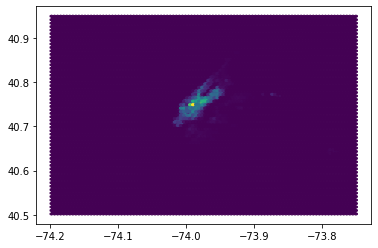

In [241]:
plt.hexbin(x,y)
plt.show()

In [242]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,...,SNWD,TMAX,TMIN,distance_traveled_km,week_day,pickup_hour,pick_col,drop_col,pick_row,drop_row
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,3.13,0.50,...,0,72,57,17.231137,0,17,79,79,49,47
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,9.84,0.00,...,0,30,20,246.295936,1,16,41,49,47,62
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,4.92,0.07,...,0,83,67,55.251875,3,0,48,46,58,55
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,4.92,0.22,...,0,71,54,38.152003,5,4,47,46,52,57
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,4.47,0.00,...,0,61,44,74.122374,1,7,51,54,59,63


try plotting a subsection of these points since it seems like most of the boxes are relatively unused, effectively zooming in

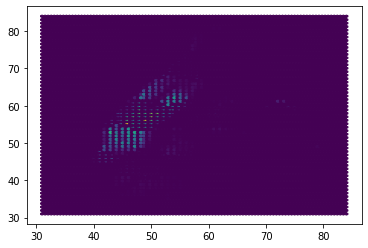

In [243]:
x_corr = np.concatenate([df['pick_col'].to_numpy(), df['drop_col'].to_numpy()])
y_corr = np.concatenate([df['pick_row'].to_numpy(), df['drop_row'].to_numpy()])

x_indexes = np.where((x_corr <= 30) | (x_corr >= 85))
y_indexes = np.where((y_corr <= 30) | (y_corr >= 85))

# get the unique index positions of the observations that don't fit to filter them out
indexes = np.unique(np.concatenate([x_indexes, y_indexes], axis=1))

# filter the x and y coordinates and then plot
x_fil = np.delete(x_corr, indexes)
y_fil = np.delete(y_corr, indexes)

plt.hexbin(x_fil,y_fil)
plt.show()

Now find the 100 most densely populated (x, y) pairs in the grid 

In [244]:
import collections

pair_occurances = collections.defaultdict(int)
for n in range(len(x_corr)):
    #pair = x_corr[n], y_corr[n]
    pair_occurances[x_corr[n], y_corr[n]] +=1

# sort by descending order of occurances 
pair_occurances = collections.OrderedDict(sorted(pair_occurances.items(), key=lambda t: t[1], reverse=True))
# convert to list
pair_occurances = [list(n) for n in list(pair_occurances.keys())]
# get 100 most common pairs
top_100 = pair_occurances[:100]

Now that I have the 100 most common pairs, find all of the observations that fit inside them and use those for the analysis

In [245]:
# first reset the indexes so that I can iterate through the rows
df = df.reset_index(drop=True)

df_top = [[] for i in range(100)]

for n in range(len(df)):
    if [df['pick_col'][n], df['pick_row'][n]] in top_100:
        df_top[top_100.index([df['pick_col'][n], df['pick_row'][n]])].append(n)
    if [df['drop_col'][n], df['drop_row'][n]] in top_100:
        df_top[top_100.index([df['drop_col'][n], df['drop_row'][n]])].append(n)

Now that we're able to segment the observations by zone, find the average percent difference between what the model from the last project would predict the fare price should be and what they actually were for different weather conditions

In [346]:
df_snow['fare_amount'].mean()

7.743396226415095

In [392]:
df_ns = df[df['SNOW'] < 6]

In [379]:
df_50 = df[(df['distance_traveled_km'] < 50) & (df['distance_traveled_km'] > 30)]
len(df_50)

136467

In [380]:
df_100 = df[(df['distance_traveled_km'] < 100) & (df['distance_traveled_km'] > 50)]
len(df_100)

269556

In [417]:
snow_dif = []
rain_dif = []

n = df_top[90]

snow_average = 0
ns_average = 0

rain_average = 0
nr_average = 0

df_i = df[df.index.isin(n)]

df_snow = df_i[df_i['SNOW'] >= 6]
df_ns = df_i[df_i['SNOW'] < 6]

df_rain = df_i[df_i['PRCP'] >= (0.15 * 24)]
df_nr = df_i[df_i['PRCP'] < (0.15 * 24)]

# to account for distance, find averages for each of the distance buckets
snow_average += df_snow[df_snow['distance_traveled_km'] < 30]['fare_amount'].mean()
ns_average += df_ns[df_ns['distance_traveled_km'] < 30]['fare_amount'].mean()

print(snow_average)

snow_average += df_snow[(df_snow['distance_traveled_km'] < 50) & (df_snow['distance_traveled_km'] > 30)]['fare_amount'].mean()
ns_average += df_ns[(df_ns['distance_traveled_km'] < 50) & (df_ns['distance_traveled_km'] > 30)]['fare_amount'].mean()

print(snow_average)

snow_average += df_snow[(df_snow['distance_traveled_km'] < 100) & (df_snow['distance_traveled_km'] > 50)]['fare_amount'].mean()
ns_average += df_ns[(df_ns['distance_traveled_km'] < 100) & (df_ns['distance_traveled_km'] > 50)]['fare_amount'].mean()

print(snow_average)

snow_average += df_snow[df_snow['distance_traveled_km'] > 100]['fare_amount'].mean()
ns_average += df_ns[df_ns['distance_traveled_km'] > 100]['fare_amount'].mean()

print(snow_average)

snow_average = snow_average / 4
ns_average = no_snow_average / 4

print(snow_average)

rain_average += df_rain[df_rain['distance_traveled_km'] < 30]['fare_amount'].mean()
nr_average += df_nr[df_nr['distance_traveled_km'] < 30]['fare_amount'].mean()

rain_average += df_rain[(df_rain['distance_traveled_km'] < 50) & (df_rain['distance_traveled_km'] > 30)]['fare_amount'].mean()
nr_average += df_nr[(df_nr['distance_traveled_km'] < 50) & (df_nr['distance_traveled_km'] > 30)]['fare_amount'].mean()

rain_average += df_rain[(df_rain['distance_traveled_km'] < 100) & (df_rain['distance_traveled_km'] > 50)]['fare_amount'].mean()
nr_average += df_nr[(df_nr['distance_traveled_km'] < 100) & (df_nr['distance_traveled_km'] > 50)]['fare_amount'].mean()

rain_average += df_snow[df_snow['distance_traveled_km'] > 100]['fare_amount'].mean()
nr_average += df_ns[df_ns['distance_traveled_km'] > 100]['fare_amount'].mean()

rain_average = rain_average / 4
nr_average = no_rain_average / 4

print(snow_average)

snow_dif.append((snow_average - ns_average) / ns_average * 100.0)
rain_dif.append((rain_average - nr_average) / nr_average * 100.0)


print(snow_average)
print(snow_dif)
print(rain_dif)

3.233333333333333
9.233333333333333
15.033333333333331
25.273333333333333
6.318333333333333
6.318333333333333
6.318333333333333
[46.481506660118704]
[inf]


<ipython-input-417-efae2c11537f>:68: RuntimeWarning: divide by zero encountered in double_scalars
  rain_dif.append((rain_average - nr_average) / nr_average * 100.0)


In [405]:
df_snow[(df_snow['distance_traveled_km'] < 50) & (df_snow['distance_traveled_km'] > 30)]['fare_amount'].mean()

6.0

In [401]:
snow_dif

[fare_amount            -11.648971
 pickup_longitude         5.381800
 pickup_latitude         -4.410786
 dropoff_longitude        5.383816
 dropoff_latitude        -4.411758
 passenger_count        -13.337951
 AWND                     4.644292
 PRCP                    -8.095598
 SNOW                    32.828161
 SNWD                    10.260239
 TMAX                   -36.638381
 TMIN                   -36.741338
 distance_traveled_km    -3.383489
 week_day               -10.796454
 pickup_hour             -6.708811
 pick_col                -3.456052
 drop_col                -3.791974
 pick_row                -2.571883
 drop_row                -2.871399
 dtype: float64]

In [396]:
snow_dif = []
rain_dif = []

for n in df_top:
    snow_average = 0
    no_snow_average = 0
    
    rain_average = 0
    no_rain_average = 0
    
    df_i = df[df.index.isin(n)]
    
    df_snow = df_i[df_i['SNOW'] >= 6]
    df_ns = df_i[df_i['SNOW'] < 6]
    
    df_rain = df_i[df_i['PRCP'] >= (0.15 * 24)]
    df_nr = df_i[df_i['PRCP'] < (0.15 * 24)]
    
    
    # to account for distance, find averages for each of the distance buckets
    snow_average += df_snow[df_snow['distance_traveled_km'] < 30]['fare_amount'].mean()
    no_snow_average += df_ns[df_ns['distance_traveled_km'] < 30]['fare_amount'].mean()
    
    snow_average += df_snow[(df_snow['distance_traveled_km'] < 50) & (df_snow['distance_traveled_km'] > 30)]['fare_amount'].mean()
    no_snow_average += df_ns[(df_ns['distance_traveled_km'] < 50) & (df_ns['distance_traveled_km'] > 30)]['fare_amount'].mean()
    
    snow_average += df_snow[(df_snow['distance_traveled_km'] < 100) & (df_snow['distance_traveled_km'] > 50)].mean()
    no_snow_average += df_ns[(df_ns['distance_traveled_km'] < 100) & (df_ns['distance_traveled_km'] > 50)].mean()
    
    snow_average += df_snow[df_snow['distance_traveled_km'] > 100]['fare_amount'].mean()
    no_snow_average += df_ns[df_ns['distance_traveled_km'] > 100]['fare_amount'].mean()
    
    snow_average = snow_average / 4
    no_snow_average = no_snow_average / 4
    
    

    rain_average += df_rain[df_rain['distance_traveled_km'] < 30]['fare_amount'].mean()
    no_rain_average += df_nr[df_nr['distance_traveled_km'] < 30]['fare_amount'].mean()
    
    rain_average += df_rain[(df_rain['distance_traveled_km'] < 50) & (df_rain['distance_traveled_km'] > 30)]['fare_amount'].mean()
    no_rain_average += df_nr[(df_nr['distance_traveled_km'] < 50) & (df_nr['distance_traveled_km'] > 30)]['fare_amount'].mean()
    
    rain_average += df_rain[(df_rain['distance_traveled_km'] < 100) & (df_rain['distance_traveled_km'] > 50)].mean()
    no_rain_average += df_nr[(df_nr['distance_traveled_km'] < 100) & (df_nr['distance_traveled_km'] > 50)].mean()
    
    rain_average += df_snow[df_snow['distance_traveled_km'] > 100]['fare_amount'].mean()
    no_rain_average += df_ns[df_ns['distance_traveled_km'] > 100]['fare_amount'].mean()
    
    rain_average = rain_average / 4
    no_rain_average = no_rain_average / 4   
    
    snow_dif.append((snow_average - no_snow_average) / no_snow_average * 100.0)
    rain_dif.append((rain_average - no_rain_average) / no_rain_average * 100.0)

In [397]:
snow_dif

[fare_amount             -5.328162
 pickup_longitude         3.906941
 pickup_latitude         -2.787861
 dropoff_longitude        3.910094
 dropoff_latitude        -2.793522
 passenger_count         -6.747787
 AWND                     4.384009
 PRCP                    -3.668637
 SNOW                    26.037917
 SNWD                    14.437369
 TMAX                   -33.905684
 TMIN                   -34.682321
 distance_traveled_km    -1.485510
 week_day                -6.955190
 pickup_hour             -3.052816
 pick_col                -2.091261
 drop_col                -2.535378
 pick_row                -1.554170
 drop_row                -2.580405
 dtype: float64,
 fare_amount             -4.542605
 pickup_longitude         2.303216
 pickup_latitude         -1.733710
 dropoff_longitude        2.310863
 dropoff_latitude        -1.734593
 passenger_count         -4.705113
 AWND                     4.194171
 PRCP                    -0.943568
 SNOW                    29.195762
 SN

In [387]:
snow_dif[0]

fare_amount             17.788571
pickup_longitude        -8.883365
pickup_latitude          8.040774
dropoff_longitude       -8.880296
dropoff_latitude         8.034758
passenger_count         22.818445
AWND                    32.149560
PRCP                    29.285820
SNOW                    69.326748
SNWD                    52.701330
TMAX                   -28.505004
TMIN                   -28.219339
distance_traveled_km     5.613719
week_day                20.786501
pickup_hour             16.657269
pick_col                 7.831372
drop_col                 7.387649
pick_row                 7.319923
drop_row                 6.240847
dtype: float64

30

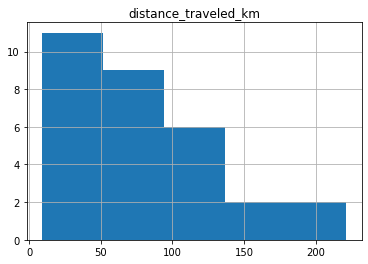

In [354]:
#df_snow['distance_traveled_km']

snow_km = df_snow.hist(column='distance_traveled_km', bins=5)

len(df_snow)

In [348]:
snow_dif

[-5.837667854726199,
 -6.414924966841607,
 -1.1924155668476,
 -5.547935298836332,
 -5.333090369144328,
 -16.043805044207986,
 -6.585152417560813,
 -8.311624867605765,
 -14.720754086564583,
 -5.411233236363669,
 -7.90693641493809,
 -11.087463155988802,
 1.724215935210976,
 -12.35910666459756,
 -13.231930386428644,
 -11.28605353764547,
 -9.600942422359775,
 -6.1161313323811735,
 -9.02861016603907,
 -7.678897560172883,
 -12.04270684357113,
 -3.4001511299086107,
 -14.981826651135737,
 -8.67643524918624,
 -9.371955775491884,
 -18.52985792548004,
 -14.123768146416884,
 -8.17006176628096,
 -6.204396551002601,
 -10.080187353379142,
 -7.518399605135008,
 1.6109475888145128,
 -4.956330522742912,
 -5.6765799159427495,
 -11.12341652068234,
 -6.934191230833883,
 -19.255358384598495,
 -2.5259498985903788,
 -4.383908224478724,
 9.014252392878868,
 -7.3472369341241865,
 -4.018220624717271,
 -17.016480135237018,
 0.6023293615436024,
 -5.2902609093247746,
 6.241064324192836,
 9.184011141262062,
 -5.0384

In [349]:
rain_dif

[5.248809904146349,
 0.5528663167261697,
 -0.6642980350912762,
 4.568391184348999,
 12.014939235744503,
 -3.182784459780494,
 6.163796399887752,
 3.1488783876530606,
 9.045551471631548,
 3.059631878886587,
 -0.21352832930916893,
 1.6842059321454999,
 -4.9084837590779005,
 12.976818054871206,
 0.21190856887511314,
 12.976765394439632,
 33.04341357357685,
 -8.968919398607387,
 -3.851223624372647,
 10.042631778439338,
 -2.7540791724540292,
 42.92417776487636,
 10.653992215890943,
 10.505808540201391,
 -9.575811194400744,
 6.586901956899317,
 2.9388224822772746,
 -3.179916643159998,
 -3.0896903092761168,
 10.184416646150733,
 0.5144534556074143,
 11.06545085108096,
 -2.6387986770070224,
 -1.1791369920830983,
 0.6802611964008087,
 0.012660506788258167,
 -13.378377141268228,
 -15.55111067630324,
 10.103402868732388,
 -5.371115517917964,
 -16.94698682482583,
 -15.365428129778207,
 -2.2140265783972035,
 -1.2213942191547598,
 2.1243939279965884,
 6.484383586680957,
 1.7501970611304831,
 15.0215

Start by recreating the model

Now, for each of the zones, segment into conditions of heavy snow and rain. Then find the average percent difference between the fare amount predicted by the model and the actual fare amount

To try to figure out what constitutes bad weather, figure out the distributions of the PRCP and SNOW features

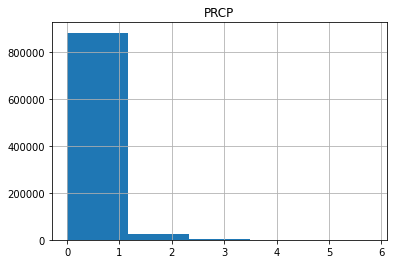

In [268]:
rain = df.hist(column='PRCP', bins=5)

In [270]:
df['PRCP'].describe()

count    909377.000000
mean          0.136708
std           0.385400
min           0.000000
25%           0.000000
50%           0.000000
75%           0.050000
max           5.810000
Name: PRCP, dtype: float64

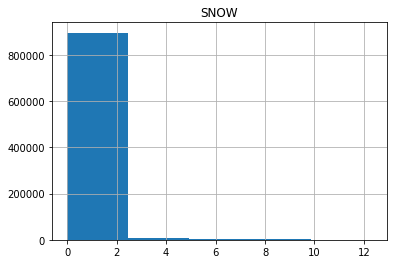

In [269]:
snow = df.hist(column='SNOW', bins=5)

In [271]:
df['SNOW'].describe()

count    909377.000000
mean          0.097136
std           0.744182
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.300000
Name: SNOW, dtype: float64

According the NOAA, snowfall accumulating to 6" or more in depth in 24 hours or less is considered heavy snowfall, so that will be my cutoff for heavy snow. Also according to NOAA, moderate rainfall measures 0.10 to 0.30 inches of rain per hour and heavy rainfall is more than 0.30 inches of rain per hour. Since this data is over a 24 hour period, I'll say that 0.15 * 24 inches of rain will qualify as heavy rain.

In [309]:
df_snow.iloc[i]['fare_amount']

6.1

In [310]:
snow_pred[i]

10.726355524768103

In [307]:
snow_pred[i]

10.74259741580784

In [317]:
i = 0

In [333]:
df_top[0][0]

2

In [334]:
df_i = df[df.index.isin(df_top[2])]

In [335]:
df_i

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,...,SNWD,TMAX,TMIN,distance_traveled_km,week_day,pickup_hour,pick_col,drop_col,pick_row,drop_row
5,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,2011-01-06,2.68,0.00,...,2,33,26,180.845705,3,9,44,50,51,57
35,9.8,2009-03-02 20:42:49 UTC,-73.972673,40.759186,-73.969897,40.791367,1,2009-03-02,10.96,0.49,...,7,28,16,34.301242,0,20,50,51,57,64
100,11.3,2010-03-22 10:01:00 UTC,-74.007670,40.732177,-73.974663,40.758932,1,2010-03-22,5.59,1.34,...,0,57,50,212.096923,0,10,43,50,51,57
147,6.5,2011-04-27 13:19:48 UTC,-73.971541,40.764009,-73.975937,40.755971,1,2011-04-27,6.93,0.00,...,0,75,61,28.984732,2,13,51,50,58,57
149,8.0,2014-11-04 12:11:19 UTC,-73.975189,40.759095,-73.980510,40.767610,1,2014-11-04,4.70,0.00,...,0,68,53,34.860929,1,12,50,49,57,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909261,11.7,2010-04-21 17:11:00 UTC,-73.991993,40.759220,-73.972663,40.759600,2,2010-04-21,6.71,0.03,...,0,69,53,123.151994,2,17,46,50,57,57
909289,12.1,2010-11-28 09:55:31 UTC,-74.003825,40.715919,-73.975160,40.755737,1,2010-11-28,4.47,0.00,...,0,47,34,187.120534,6,9,43,50,48,57
909331,11.0,2013-12-21 12:22:00 UTC,-73.974407,40.757022,-73.990200,40.756697,2,2013-12-21,7.83,0.01,...,1,65,51,100.617709,5,12,50,46,57,57
909350,22.5,2013-07-16 08:46:00 UTC,-74.007533,40.725687,-73.972683,40.758247,1,2013-07-16,4.70,0.00,...,0,94,77,224.528191,1,8,43,50,50,57


In [259]:
len(df_1)

32566

In [ ]:
len(df_top[-1])

In [ ]:
df_last = df[df.index.isin(df_top[-1])]

In [ ]:
len(df_last)

In [ ]:
heavy_rain = df_last[df_last['PRCP'] > 3.6]
len(heavy_rain)

In [ ]:
heavy_snow = df_last[df_last['SNOW'] > 6]
len(heavy_snow)

In [ ]:
# so using the model for the last project, find the predictions 

In [ ]:
heavy_rain_1 = df_1[df_1['PRCP'] > 3.6]
len(heavy_rain_1)

In [ ]:
heavy_snow_1 = df_1[df_1['SNOW'] > 6]
len(heavy_snow_1)